In [1]:
import numpy as np
import gensim
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import re
import statsmodels.formula.api
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib nbagg

## Protected Groups

Race,
Color,
Religion or creed,
National origin or ancestry,
Sex,
Age,
Physical or mental disability,
Veteran status,
Genetic information,
Citizenship

In [2]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 
              'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 
              'female', 'nonbinary', 'african', 'african american', 'black', 'white', 
              'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 
              'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 
              'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 
              'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 
              'elderly', 'blind', 'deaf', 'paralyzed']

In [205]:
nationalities=[
'German',
'African_American',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'Polish',
'French',
'Scottish',
'Puerto_Rican',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'Filipino'
]

## build toxic words

In [252]:
neg_words = filter(lambda x: x.lower() in embeddings,neg_words)
pos_words = filter(lambda x: x.lower() in embeddings,pos_words)
X = np.zeros((6808,300))
for i,word in enumerate(neg_words+pos_words+nationalities):
    X[i,:] = embeddings[word.lower()]
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(X)
X = TSNE(n_components=2).fit_transform(principalComponents)
principalDf = pd.DataFrame(data = X, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.Series(train_targets)], axis = 1)

In [253]:
len(neg_words),len(pos_words),len(nationalities)

(4444, 1857, 18)

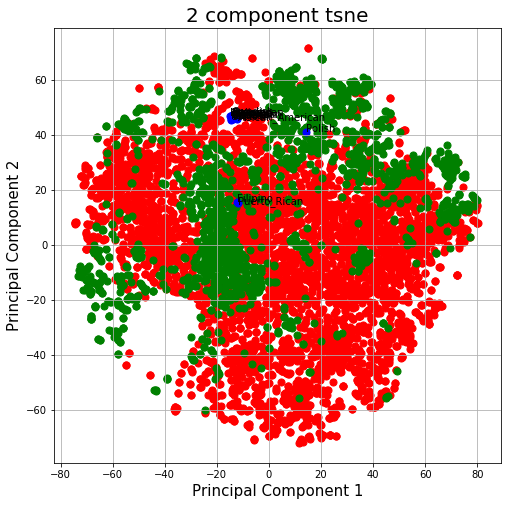

In [276]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component tsne', fontsize = 20)
targets = ['negative words','positive words','nationalities']
colors = ['r', 'g','b']
for c,t in zip(['r', 'g','b'],[(0,len(neg_words)),(len(neg_words),len(pos_words)+len(neg_words)),(len(neg_words)+len(pos_words),len(neg_words)+len(pos_words)+len(nationalities))]):
        indices = np.arange(t[0],t[1])

        ax.scatter(finalDf.loc[indices, 'principal component 1']
                   , finalDf.loc[indices, 'principal component 2']
                   , c = c
                   , s = 50)

        if c=='b':
            for i,j in zip(nationalities,indices):
                ax.annotate(i, (finalDf.loc[j, 'principal component 1'], finalDf.loc[j, 'principal component 2']))
ax.grid()

In [209]:
neg_words

['abnormal',
 'abolish',
 'abominable',
 'abominably',
 'abominate',
 'abomination',
 'abort',
 'aborted',
 'aborts',
 'abrade',
 'abrasive',
 'abrupt',
 'abruptly',
 'abscond',
 'absence',
 'absentee',
 'absurd',
 'absurdity',
 'absurdly',
 'absurdness',
 'abuse',
 'abused',
 'abuses',
 'abusive',
 'abysmal',
 'abysmally',
 'abyss',
 'accidental',
 'accost',
 'accursed',
 'accusation',
 'accusations',
 'accuse',
 'accuses',
 'accusing',
 'accusingly',
 'acerbic',
 'acerbically',
 'ache',
 'ached',
 'aches',
 'achey',
 'aching',
 'acrid',
 'acrimonious',
 'acrimoniously',
 'acrimony',
 'adamant',
 'adamantly',
 'addict',
 'addicted',
 'addicting',
 'addicts',
 'admonish',
 'admonishment',
 'admonition',
 'adulterate',
 'adulterated',
 'adulteration',
 'adversarial',
 'adversary',
 'adverse',
 'adversity',
 'afflict',
 'affliction',
 'affront',
 'afraid',
 'aggravate',
 'aggravating',
 'aggravation',
 'aggression',
 'aggressive',
 'aggressiveness',
 'aggressor',
 'aggrieve',
 'aggrieved

In [ ]:
    Ahmadiyya
    Aladura
    Amish
    Anglicanism
    Asatru
    Assemblies of God
    Atheism
    Baha'i Faith
    Baptists
    Bon
    Buddhism
    Candomble
    Cao Dai
    Cathari
    Catholicism
    Charismatic movement
    Chinese Religion
    Christadelphians
    Christian Science
    Christianity
    Church of God
    Church of God in Christ
    Church of Satan
    Confucianism
    Conservative Judaism
    Deism
    Donatism
    Dragon Rouge
    Druze
    Eastern Orthodox Church
    Eckankar
    ELCA
    Epicureanism
    Evangelicalism
    Falun Gong
    Foursquare Church
    Gnosticism
    Greek Religion
    Hare Krishna
    Hasidism
    Hellenic Reconstructionism
    Hinduism
    Illuminati
    Intelligent Design
    Islam
    Jainism
    Jehovah's Witnesses
    Judaism
    Kabbalah
    Kemetic Reconstructionism
    Lutheranism
    Mahayana Buddhism
    Mayan Religion
    Methodism
    Mithraism
    Mormonism
    Neopaganism
    New Age
    New Thought
    Nichiren
    Norse Religion
    Olmec Religion
    Oneness Pentecostalism
    Orthodox Judaism
    Pentecostalism
    Presbyterianism
    Priory of Sion
    Protestantism
    Pure Land Buddhism
    Quakers
    Rastafarianism
    Reform Judaism
    Rinzai Zen Buddhism
    Roman Religion
    Satanism
    Scientology
    Seventh-Day Adventism
    Shaivism
    Shi'a Islam
    Shinto
    Sikhism
    Soto Zen Buddhism
    Spiritualism
    Stoicism
    Sufism
    Sunni Islam
    Taoism
    Tendai Buddhism
    Theravada Buddhism
    Tibetan Buddhism
    Typhonian Order
    Umbanda
    Unification Church
    Unitarian Universalism
    Vaishnavism
    Vajrayana Buddhism
    Vedanta
    Vineyard Churches
    Voodoo
    Westboro Baptist Church
    Wicca
    Worldwide Church of God
    Yezidi
    Zen
    Zionism
    Zoroastrianism

In [216]:
races =[ 
    'Christianity',
    'Islam',
    'Atheist',
    'Hinduism',
    'Buddhism',
    'Diasporic',
    'Sikhism',
    'Juche',
    'Judaism',
    'Bahai',
    'Jainism',
    'Shinto',
    'Zoroastrianism',
    'Paganism',
]

In [3]:
def words_to_toxicity(model,embeddings,words):
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        vector = np.mean(embeddings[words],axis = 0)
        prob = model.predict_proba([vector])
        return prob[0][0]
    else: return 0;

In [4]:
def text_to_toxicity(model,embeddings,text):
    tokens = text.split()
    toxicity = words_to_toxicity(model,embeddings,tokens)
    return toxicity

In [164]:
def identity_toxicity_table(identities,embeddings,model,add=None):
    words = []
    toxicities = []
    for word in sorted(identities):
        word = add + word if add else word
        word = word.lower()
        if word in embeddings:
            toxicities.append(text_to_toxicity(model, embeddings,word.lower()))
            words.append(word)
    return zip(words,toxicities)

In [28]:
def load_lexicon(filename):
    lexicon = []
    with open(filename) as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [7]:
# embeddings_debiased = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300-hard-debiased.bin', binary=True)
embeddings = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
embeddings_debiased = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/numberbatch.txt',)
pos_words = load_lexicon("data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("data/opinion_lexicon/negative-words.txt")

## train new corpus toxicity classifier

In [19]:
pos_words_fil_debiased = filter(lambda x:  x in embeddings_debiased,map(lambda x: '/c/en/'+ x,pos_words))
neg_words_fil_debiased = filter(lambda x:  x in embeddings_debiased,map(lambda x: '/c/en/'+ x,neg_words))
pos_vectors = embeddings_debiased[pos_words_fil_debiased]
neg_vectors = embeddings_debiased[neg_words_fil_debiased]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors] + [-1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
model_debias = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors, train_targets)
preds =model_debias.predict(test_vectors)
(preds == test_targets).mean()

0.9682034976152624

## train debiased news corpus toxicity classifier

In [21]:
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors] + [-1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
model = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors, train_targets)
preds =model.predict(test_vectors)
(preds == test_targets).mean()

0.9477020602218701

## test toxicity on gender equalized vs non equalized

In [41]:
text_to_toxicity(model_debias,embeddings_debiased,'/c/en/'+'gay'),text_to_toxicity(model,embeddings,"gay")

(0.3588644596023533, 0.9744714403633258)

## create identity keyword toxicity histograms

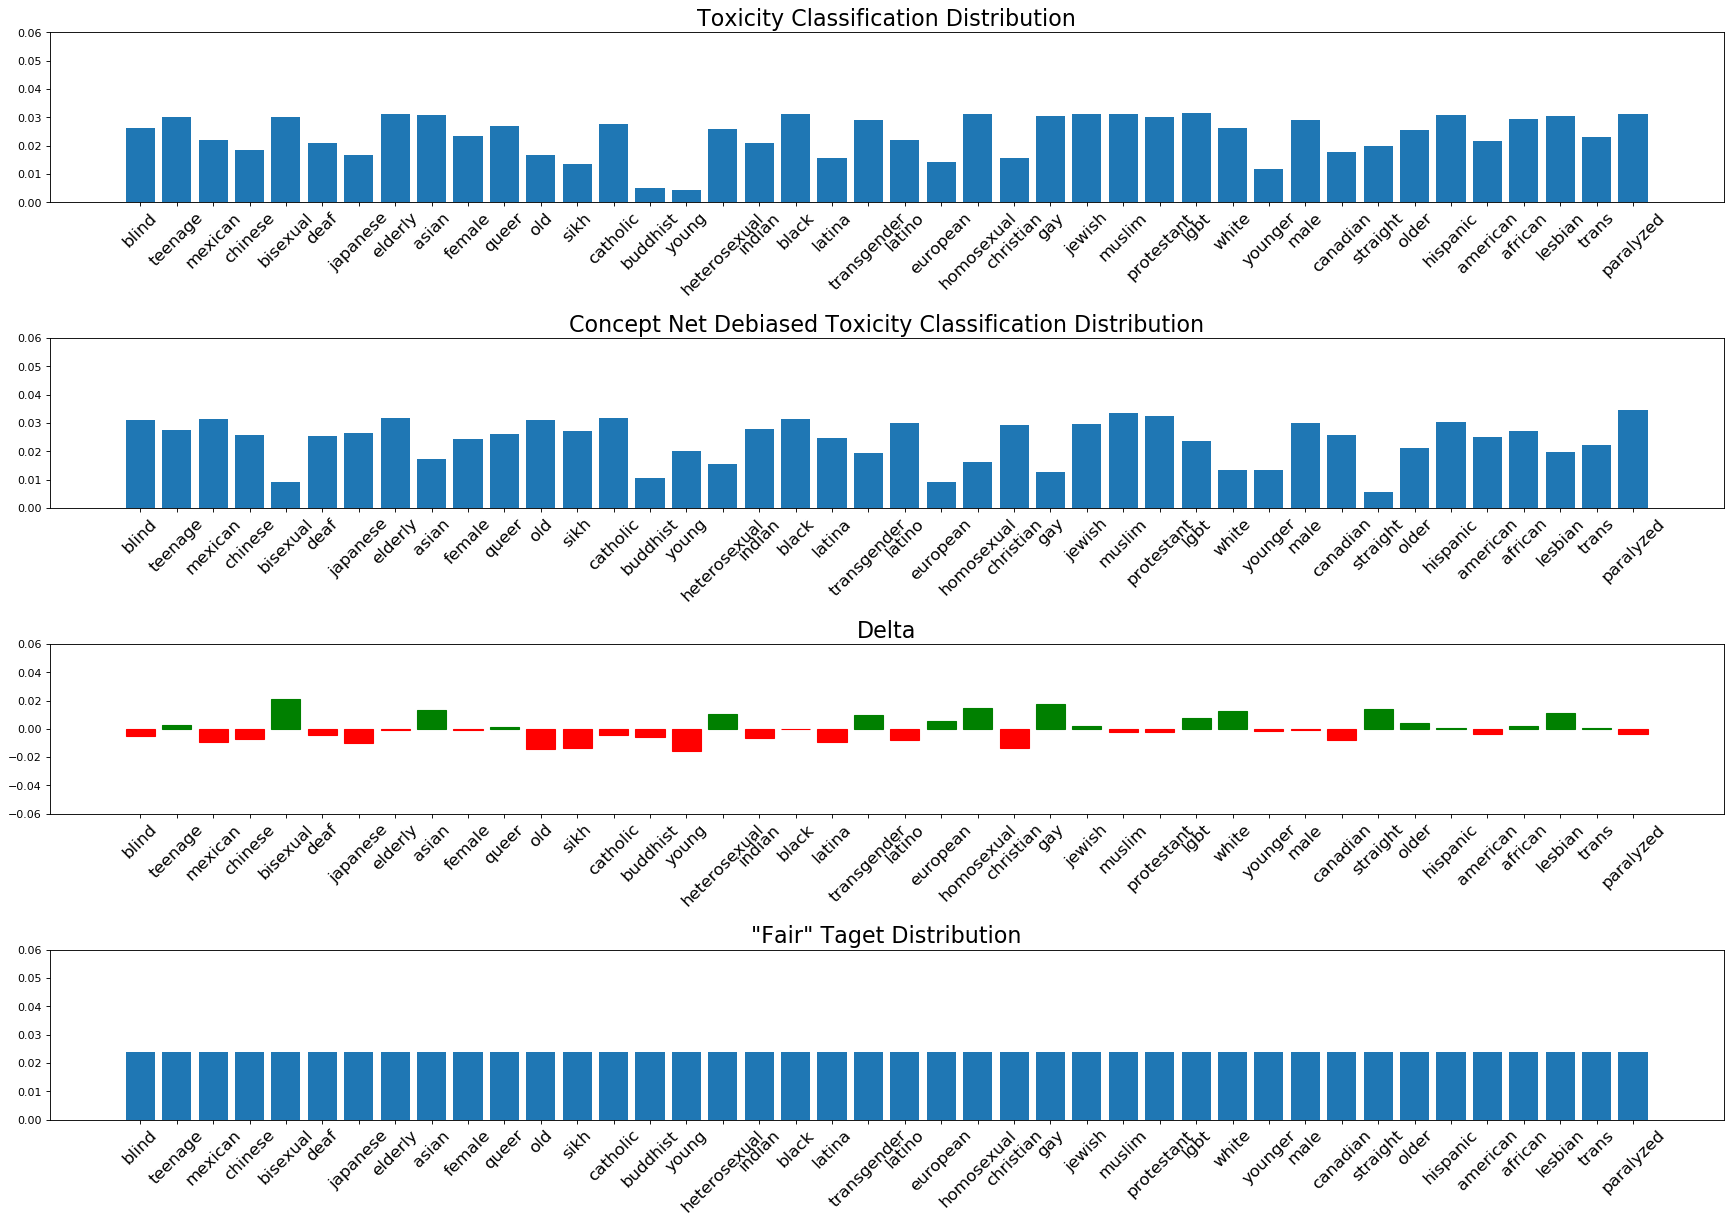

kl divergence from uniform dist for concept net: 0.05779202343063937
kl divergence from uniform dist for google news: 0.055767841113624254


In [171]:
identity_toxicity_debias = dict(identity_toxicity_table(identities, embeddings_debiased,model_debias,add='/c/en/'))
identity_toxicity = dict(identity_toxicity_table(identities,embeddings,model))
keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
identity_toxicity_debias = {key: identity_toxicity_debias['/c/en/'+key] for key in keys_common }
identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=.8)
f.add_subplot(411)
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
f.add_subplot(412)
plt.title("Concept Net Debiased Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
f.add_subplot(413)
plt.title("Delta",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=-.06)
f.add_subplot(414)
plt.title('"Fair" Taget Distribution',fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

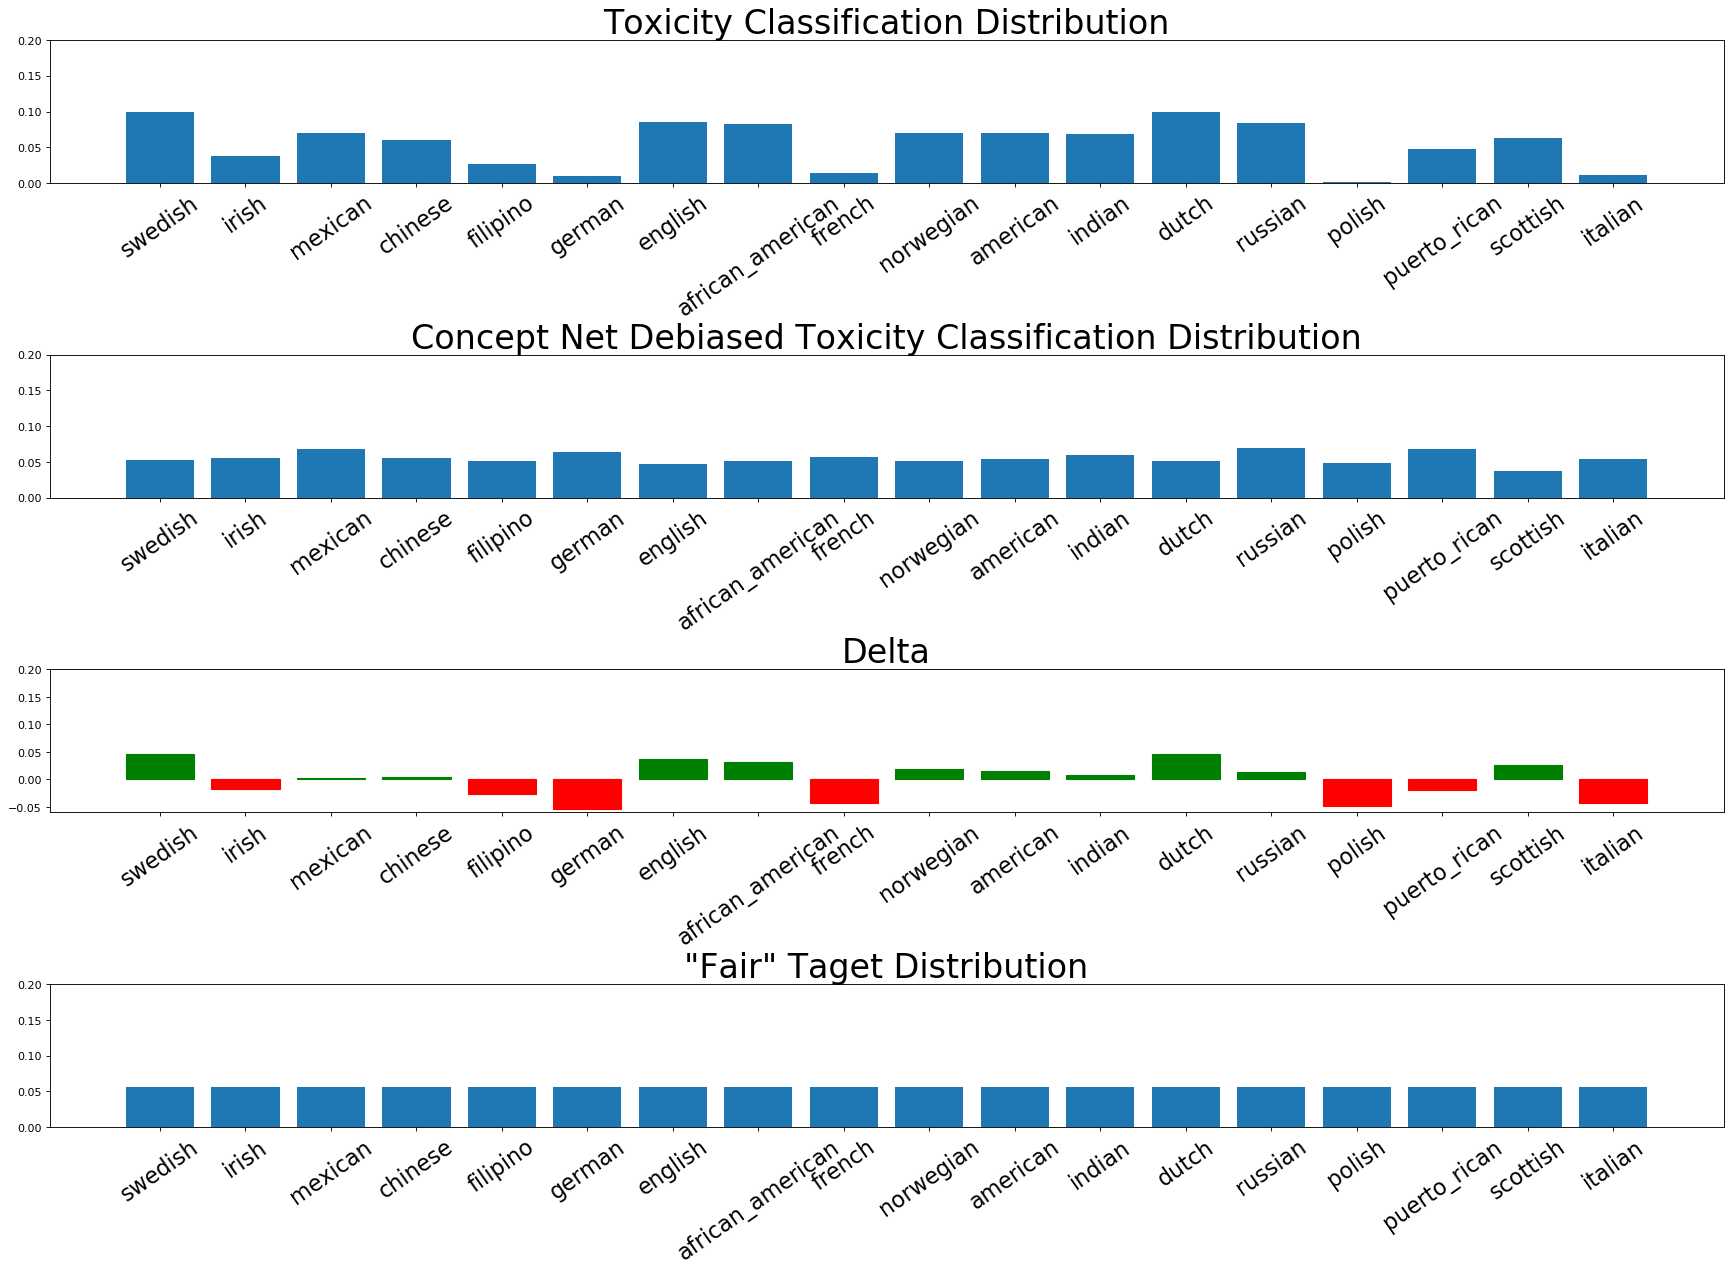

kl divergence from uniform dist for concept net: 0.010194184417816068
kl divergence from uniform dist for google news: 0.19450034674063088


In [227]:
identity_toxicity_debias = dict(identity_toxicity_table(nationalities, embeddings_debiased,model_debias,add='/c/en/'))
identity_toxicity = dict(identity_toxicity_table(nationalities,embeddings,model))
keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
identity_toxicity_debias = {key: identity_toxicity_debias['/c/en/'+key] for key in keys_common }
identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=1.2)
f.add_subplot(411)
plt.title("Toxicity Classification Distribution",fontsize=30)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=20, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(412)
plt.title("Concept Net Debiased Toxicity Classification Distribution",fontsize=30)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=20, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(413)
plt.title("Delta",fontsize=30)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=20, rotation=35)
plt.ylim(top=.2,bottom=-.06)
f.add_subplot(414)
plt.title('"Fair" Taget Distribution',fontsize=30)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=20, rotation=35)
plt.ylim(top=.2,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

In [228]:
identity_toxicity[0]

('swedish',
 'irish',
 'mexican',
 'chinese',
 'filipino',
 'german',
 'english',
 'african_american',
 'french',
 'norwegian',
 'american',
 'indian',
 'dutch',
 'russian',
 'polish',
 'puerto_rican',
 'scottish',
 'italian')

In [231]:
np.shape(identity_toxicity[1]),np.shape(np.transpose(identity_toxicity_debias[1]))

((18,), (18,))

In [242]:
identity_toxicity_debias[1]

(0.6948515568192463,
 0.7314236947492622,
 0.8900669204738267,
 0.7264362399134886,
 0.6802756199667686,
 0.840674386144298,
 0.6233768203310069,
 0.676420241571403,
 0.7517792727984568,
 0.6679760944536062,
 0.7111686803047913,
 0.7877906097738091,
 0.6818230008175887,
 0.9151894189465483,
 0.6361441206958623,
 0.888842495212234,
 0.4899446465527032,
 0.7059972929448228)

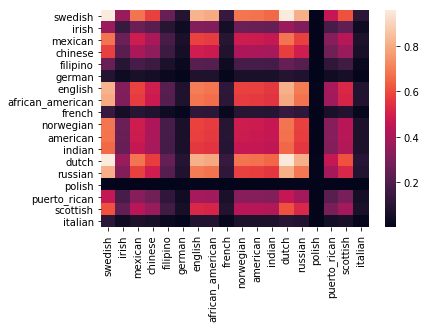

In [243]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline
A = np.outer(identity_toxicity[1],identity_toxicity[1])

df = DataFrame(A, index=identity_toxicity[0], columns=identity_toxicity[0])

sns.heatmap(df, annot=False,)

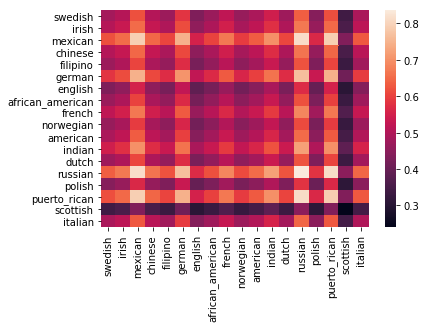

In [247]:
A = np.outer(identity_toxicity_debias[1],identity_toxicity_debias[1])

df = DataFrame(A, index=identity_toxicity_debias[0], columns=identity_toxicity_debias[0])

sns.heatmap(df, annot=False,)

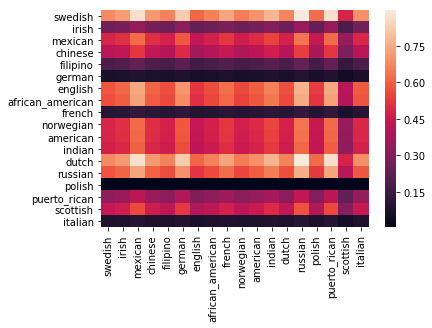

In [248]:
A = np.outer(identity_toxicity[1],identity_toxicity_debias[1])

df = DataFrame(A, index=identity_toxicity[0], columns=identity_toxicity_debias[0])

sns.heatmap(df, annot=False,)

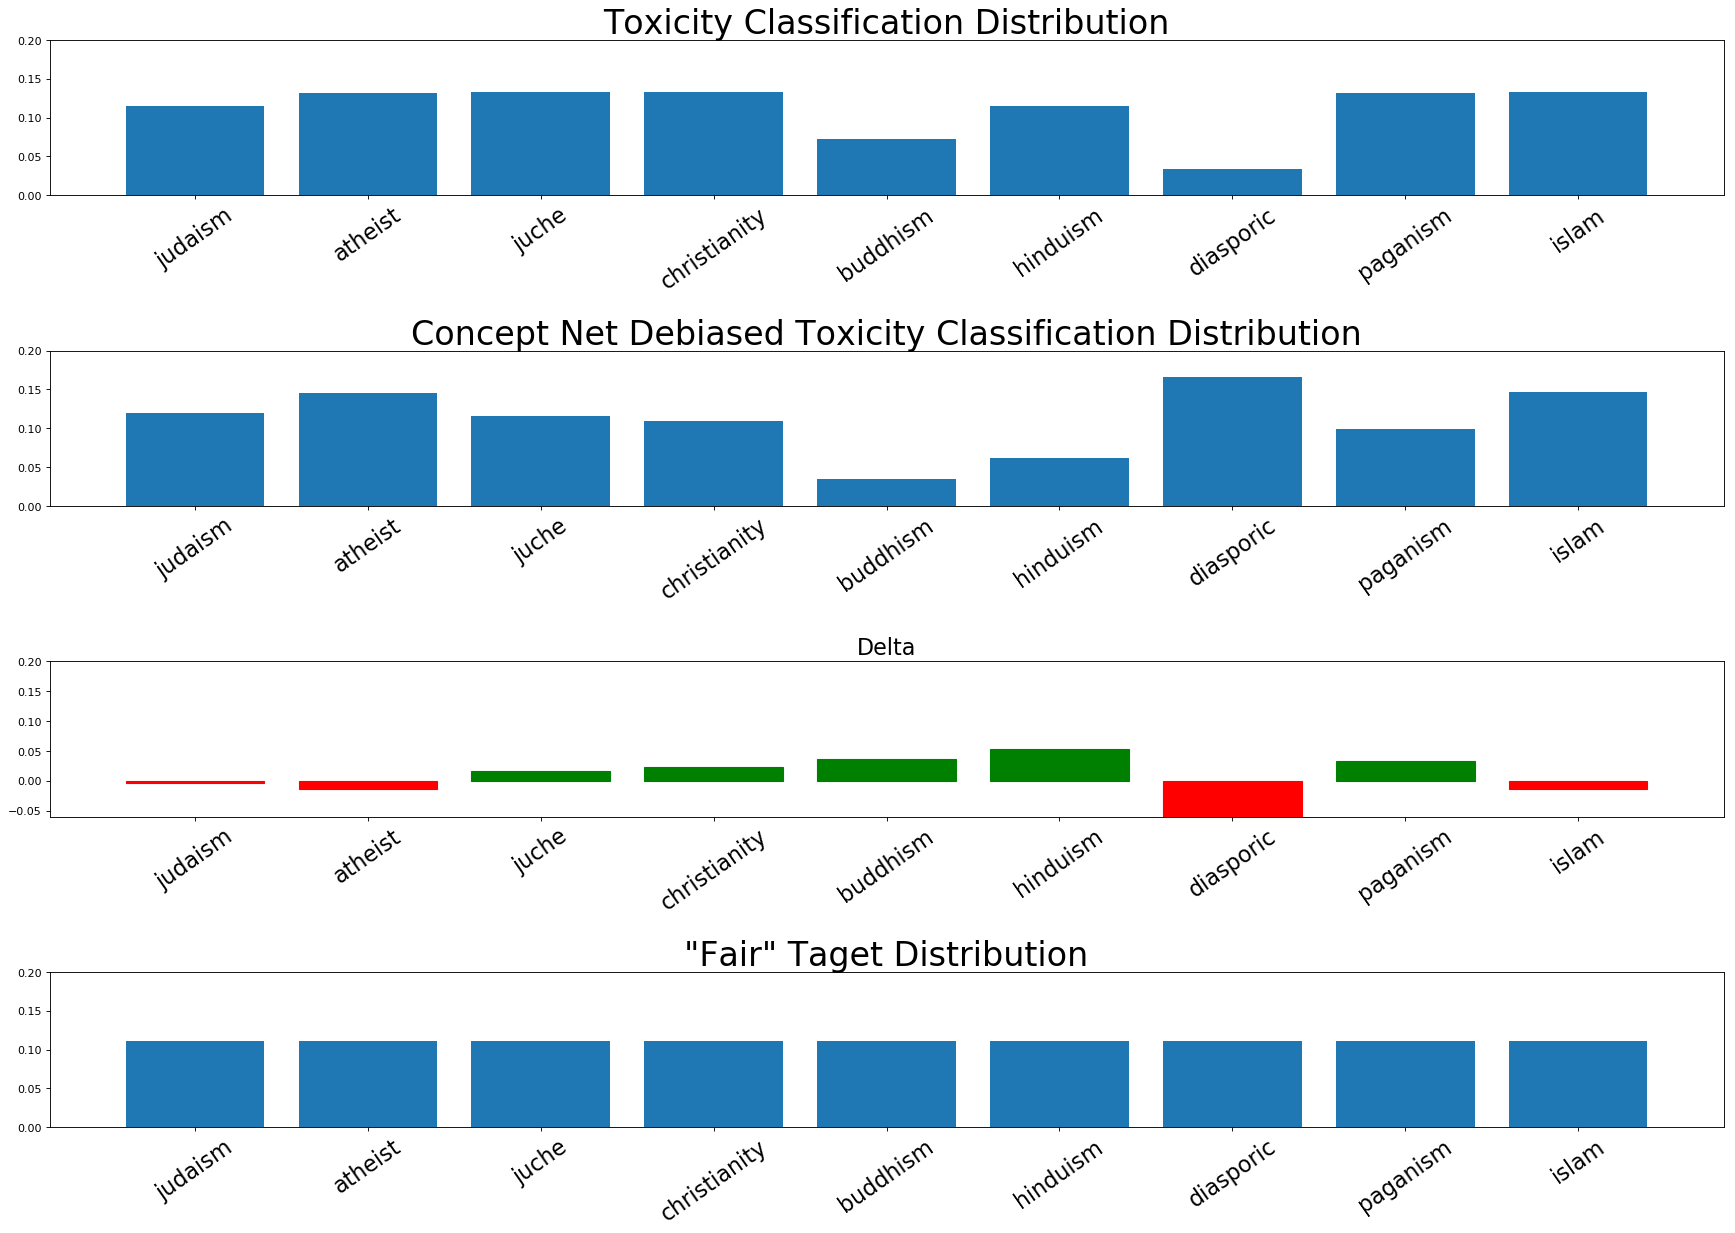

kl divergence from uniform dist for concept net: 0.0718141469449135
kl divergence from uniform dist for google news: 0.05457678207331278


In [225]:
identity_toxicity_debias = dict(identity_toxicity_table(races, embeddings_debiased,model_debias,add='/c/en/'))
identity_toxicity = dict(identity_toxicity_table(races,embeddings,model))
keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
identity_toxicity_debias = {key: identity_toxicity_debias['/c/en/'+key] for key in keys_common }
identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=1)
f.add_subplot(411)
plt.title("Toxicity Classification Distribution",fontsize=30)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=20, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(412)
plt.title("Concept Net Debiased Toxicity Classification Distribution",fontsize=30)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=20, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(413)
plt.title("Delta",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=20, rotation=35)
plt.ylim(top=.2,bottom=-.06)
f.add_subplot(414)
plt.title('"Fair" Taget Distribution',fontsize=30)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=20, rotation=35)
plt.ylim(top=.2,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

## Toxicity Variance in histogram debiased vs non debiased

In [107]:
np.var(identity_toxicity_debias[1]),np.var(identity_toxicity[1])

(0.04579002936934977, 0.05427756124016946)

## KL Divergence from uniform dist

In [170]:
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

kl divergence from uniform dist for concept net: 0.0856863559174515
kl divergence from uniform dist for google news: 0.1503998601112115
